#### Библиотеки

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
import re
import spacy
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec
from transformers import AutoTokenizer, AutoModel
import torch
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score, confusion_matrix, log_loss
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, Model
from transformers import AutoTokenizer, TFAutoModel
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import optuna
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns


#### Подготовка корпуса текстов

In [24]:
def load_corpus(filename):
    return pd.read_json(filename, lines=True)

def prepare_corpus(df):
    df = df.copy()
    df['categories'] = df['category'].apply(lambda x: [x])
    return df

def balance_dataset(df, target_size=10000):
    category_counts = df['category'].value_counts()
    min_category = min(category_counts.min(), target_size // len(category_counts))
    
    balanced_dfs = []
    for category in df['category'].unique():
        category_df = df[df['category'] == category]
        if len(category_df) > min_category:
            category_df = category_df.sample(min_category, random_state=42)
        balanced_dfs.append(category_df)
    
    return pd.concat(balanced_dfs).sample(frac=1, random_state=42)

def split_dataset(df):
    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['category'])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['category'])
    return train_df, val_df, test_df

def save_datasets(train_df, val_df, test_df, labeled_df):
    labeled_df.to_json('labeled_corpus.jsonl', orient='records', lines=True, force_ascii=False)
    train_df.to_json('train.jsonl', orient='records', lines=True, force_ascii=False)
    val_df.to_json('validation.jsonl', orient='records', lines=True, force_ascii=False)
    test_df.to_json('test.jsonl', orient='records', lines=True, force_ascii=False)

def print_stats(df, name):
    print(f"\n{name}:")
    print(f"Размер: {len(df)}")
    print("Распределение категорий:")
    print(df['category'].value_counts())

corpus_df = load_corpus('corpus.jsonl')
print(f"Загружено документов: {len(corpus_df)}")

labeled_df = prepare_corpus(corpus_df)
print("Подготовка корпуса завершена")

balanced_df = balance_dataset(labeled_df)
print(f"После балансировки: {len(balanced_df)} документов")

train_df, val_df, test_df = split_dataset(balanced_df)

print_stats(balanced_df, "Общий корпус")
print_stats(train_df, "Обучающая выборка")
print_stats(val_df, "Валидационная выборка")
print_stats(test_df, "Тестовая выборка")

save_datasets(train_df, val_df, test_df, balanced_df)
print("\nДатасеты сохранены")

Загружено документов: 200
Подготовка корпуса завершена
После балансировки: 126 документов

Общий корпус:
Размер: 126
Распределение категорий:
category
Общество        18
Политика        18
Культура        18
Экономика       18
Происшествия    18
Мир             18
РИА Новости     18
Name: count, dtype: int64

Обучающая выборка:
Размер: 88
Распределение категорий:
category
Мир             13
Культура        13
РИА Новости     13
Общество        13
Экономика       12
Политика        12
Происшествия    12
Name: count, dtype: int64

Валидационная выборка:
Размер: 19
Распределение категорий:
category
Экономика       3
Политика        3
Происшествия    3
Мир             3
РИА Новости     3
Общество        2
Культура        2
Name: count, dtype: int64

Тестовая выборка:
Размер: 19
Распределение категорий:
category
Политика        3
Экономика       3
Происшествия    3
Общество        3
Культура        3
РИА Новости     2
Мир             2
Name: count, dtype: int64

Датасеты сохранены


#### Подготовка данных

In [13]:
def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def lowercase_text(text):
    return text.lower()

def tokenize_text(text, nlp_model):
    doc = nlp_model(text)
    return [token.text for token in doc]

def lemmatize_text(text, nlp_model):
    doc = nlp_model(text)
    return [token.lemma_ for token in doc]

def remove_stopwords(tokens, stopwords_list):
    return [token for token in tokens if token not in stopwords_list]

def preprocess_pipeline(texts, nlp_model, use_lemmatization=True, remove_stopwords_flag=True):
    processed_texts = []
    stopwords_list = set(stopwords.words('russian')) if remove_stopwords_flag else set()
    
    for text in texts:
        cleaned = clean_text(text)
        lowercased = lowercase_text(cleaned)
        
        if use_lemmatization:
            tokens = lemmatize_text(lowercased, nlp_model)
        else:
            tokens = tokenize_text(lowercased, nlp_model)
            
        if remove_stopwords_flag:
            tokens = remove_stopwords(tokens, stopwords_list)
            
        processed_texts.append(' '.join(tokens))
    
    return processed_texts

def extract_bow_features(texts, max_features=5000):
    vectorizer = CountVectorizer(max_features=max_features)
    features = vectorizer.fit_transform(texts)
    return features, vectorizer

def extract_tfidf_features(texts, max_features=5000):
    vectorizer = TfidfVectorizer(max_features=max_features)
    features = vectorizer.fit_transform(texts)
    return features, vectorizer

def extract_ngram_features(texts, ngram_range=(1, 2), max_features=5000):
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    features = vectorizer.fit_transform(texts)
    return features, vectorizer

def extract_meta_features(texts):
    meta_features = []
    
    for text in texts:
        words = text.split()
        chars = len(text)
        word_count = len(words)
        unique_words = len(set(words))
        avg_word_length = np.mean([len(word) for word in words]) if words else 0
        punctuation_count = len(re.findall(r'[^\w\s]', text))
        digit_count = len(re.findall(r'\d', text))
        uppercase_count = len(re.findall(r'[A-ZА-Я]', text))
        
        meta_features.append([
            chars, word_count, unique_words, avg_word_length,
            punctuation_count / max(chars, 1),
            digit_count / max(chars, 1),
            uppercase_count / max(chars, 1)
        ])
    
    return np.array(meta_features)

def load_data(filename):
    return pd.read_json(filename, lines=True)

def main():
    nlp = spacy.load("ru_core_news_sm")
    
    df = load_data('corpus.jsonl')
    texts = df['text'].tolist()
    
    processed_texts = preprocess_pipeline(texts, nlp)
    
    bow_features, bow_vectorizer = extract_bow_features(processed_texts)
    tfidf_features, tfidf_vectorizer = extract_tfidf_features(processed_texts)
    ngram_features, ngram_vectorizer = extract_ngram_features(processed_texts)
    meta_features = extract_meta_features(processed_texts)
    
    print(f"Обработано текстов: {len(processed_texts)}")
    print(f"BOW features shape: {bow_features.shape}")
    print(f"TF-IDF features shape: {tfidf_features.shape}")
    print(f"N-gram features shape: {ngram_features.shape}")
    print(f"Meta features shape: {meta_features.shape}")

main()

Обработано текстов: 200
BOW features shape: (200, 5000)
TF-IDF features shape: (200, 5000)
N-gram features shape: (200, 5000)
Meta features shape: (200, 7)


#### Классические методы

In [16]:
def load_data():
    train_df = pd.read_json('train.jsonl', lines=True)
    val_df = pd.read_json('validation.jsonl', lines=True)
    test_df = pd.read_json('test.jsonl', lines=True)
    return train_df, val_df, test_df

def extract_features_from_text(df):
    features = []
    for text in df['text']:
        words = text.split()
        chars = len(text)
        word_count = len(words)
        unique_words = len(set(words))
        avg_word_length = np.mean([len(word) for word in words]) if words else 0
        
        features.append([chars, word_count, unique_words, avg_word_length])
    
    return np.array(features)

def encode_labels(y_train, y_val, y_test):
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_val_encoded = label_encoder.transform(y_val)
    y_test_encoded = label_encoder.transform(y_test)
    return y_train_encoded, y_val_encoded, y_test_encoded, label_encoder

def prepare_features_labels(train_df, val_df, test_df, target_column):
    X_train = extract_features_from_text(train_df)
    X_val = extract_features_from_text(val_df)
    X_test = extract_features_from_text(test_df)
    
    y_train = train_df[target_column].values
    y_val = val_df[target_column].values
    y_test = test_df[target_column].values
    
    y_train_encoded, y_val_encoded, y_test_encoded, label_encoder = encode_labels(y_train, y_val, y_test)
    
    return X_train, y_train_encoded, X_val, y_val_encoded, X_test, y_test_encoded, label_encoder

def train_logistic_regression(X_train, y_train, X_val, y_val):
    model_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=1000)
    model_l2 = LogisticRegression(penalty='l2', random_state=42, max_iter=1000)
    
    model_l1.fit(X_train, y_train)
    model_l2.fit(X_train, y_train)
    
    val_score_l1 = model_l1.score(X_val, y_val)
    val_score_l2 = model_l2.score(X_val, y_val)
    
    return model_l1, model_l2, val_score_l1, val_score_l2

def train_svm(X_train, y_train, X_val, y_val):
    model = SVC(kernel='linear', random_state=42)
    model.fit(X_train, y_train)
    val_score = model.score(X_val, y_val)
    return model, val_score

def train_random_forest(X_train, y_train, X_val, y_val):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    val_score = model.score(X_val, y_val)
    return model, val_score

def train_xgboost(X_train, y_train, X_val, y_val):
    try:
        import xgboost as xgb
        model = xgb.XGBClassifier(random_state=42)
        model.fit(X_train, y_train)
        val_score = model.score(X_val, y_val)
        return model, val_score
    except ImportError:
        return None, 0

def train_catboost(X_train, y_train, X_val, y_val):
    try:
        import catboost as cb
        model = cb.CatBoostClassifier(random_state=42, verbose=False)
        model.fit(X_train, y_train)
        val_score = model.score(X_val, y_val)
        return model, val_score
    except ImportError:
        return None, 0

def train_lightgbm(X_train, y_train, X_val, y_val):
    try:
        import lightgbm as lgb
        model = lgb.LGBMClassifier(random_state=42)
        model.fit(X_train, y_train)
        val_score = model.score(X_val, y_val)
        return model, val_score
    except ImportError:
        return None, 0

def create_bagging_classifier(X_train, y_train, X_val, y_val):
    base_model = LogisticRegression(random_state=42, max_iter=1000)
    bagging_model = BaggingClassifier(base_model, n_estimators=10, random_state=42)
    bagging_model.fit(X_train, y_train)
    val_score = bagging_model.score(X_val, y_val)
    return bagging_model, val_score

def create_voting_classifier(X_train, y_train, X_val, y_val):
    models = [
        ('lr', LogisticRegression(random_state=42, max_iter=1000)),
        ('svm', SVC(kernel='linear', probability=True, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=50, random_state=42))
    ]
    
    hard_voting = VotingClassifier(estimators=models, voting='hard')
    soft_voting = VotingClassifier(estimators=models, voting='soft')
    
    hard_voting.fit(X_train, y_train)
    soft_voting.fit(X_train, y_train)
    
    hard_score = hard_voting.score(X_val, y_val)
    soft_score = soft_voting.score(X_val, y_val)
    
    return hard_voting, soft_voting, hard_score, soft_score

def evaluate_model(model, X_test, y_test, model_name, label_encoder):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"{model_name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-score: {f1:.4f}")
    
    return accuracy, f1

def main():
    train_df, val_df, test_df = load_data()
    
    target_column = 'category'
    
    X_train, y_train, X_val, y_val, X_test, y_test, label_encoder = prepare_features_labels(
        train_df, val_df, test_df, target_column
    )
    
    print("Training models...")
    print(f"Classes: {label_encoder.classes_}")
    print(f"Training set shape: {X_train.shape}")
    
    lr_l1, lr_l2, lr_l1_score, lr_l2_score = train_logistic_regression(X_train, y_train, X_val, y_val)
    svm_model, svm_score = train_svm(X_train, y_train, X_val, y_val)
    rf_model, rf_score = train_random_forest(X_train, y_train, X_val, y_val)
    xgb_model, xgb_score = train_xgboost(X_train, y_train, X_val, y_val)
    cb_model, cb_score = train_catboost(X_train, y_train, X_val, y_val)
    lgb_model, lgb_score = train_lightgbm(X_train, y_train, X_val, y_val)
    bagging_model, bagging_score = create_bagging_classifier(X_train, y_train, X_val, y_val)
    hard_voting, soft_voting, hard_score, soft_score = create_voting_classifier(X_train, y_train, X_val, y_val)
    
    print("\nValidation Scores:")
    print(f"Logistic Regression L1: {lr_l1_score:.4f}")
    print(f"Logistic Regression L2: {lr_l2_score:.4f}")
    print(f"SVM: {svm_score:.4f}")
    print(f"Random Forest: {rf_score:.4f}")
    print(f"XGBoost: {xgb_score:.4f}")
    print(f"CatBoost: {cb_score:.4f}")
    print(f"LightGBM: {lgb_score:.4f}")
    print(f"Bagging: {bagging_score:.4f}")
    print(f"Hard Voting: {hard_score:.4f}")
    print(f"Soft Voting: {soft_score:.4f}")
    
    models = [
        (lr_l1, lr_l1_score, 'Logistic Regression L1'),
        (lr_l2, lr_l2_score, 'Logistic Regression L2'),
        (svm_model, svm_score, 'SVM'),
        (rf_model, rf_score, 'Random Forest'),
        (bagging_model, bagging_score, 'Bagging'),
        (hard_voting, hard_score, 'Hard Voting'),
        (soft_voting, soft_score, 'Soft Voting')
    ]
    
    if xgb_model:
        models.append((xgb_model, xgb_score, 'XGBoost'))
    if cb_model:
        models.append((cb_model, cb_score, 'CatBoost'))
    if lgb_model:
        models.append((lgb_model, lgb_score, 'LightGBM'))
    
    best_model = max(models, key=lambda x: x[1])
    
    print(f"\nBest model: {best_model[2]} with validation score: {best_model[1]:.4f}")
    
    print("\nTest Set Evaluation:")
    final_accuracy, final_f1 = evaluate_model(best_model[0], X_test, y_test, f"Best Model ({best_model[2]})", label_encoder)

main()

Training models...
Classes: ['Культура' 'Мир' 'Общество' 'Политика' 'Происшествия' 'РИА Новости'
 'Экономика']
Training set shape: (88, 4)


c:\Users\DmitrievMS\PycharmProjects\pythonProject\ml_nlp_venv_3_11\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\DmitrievMS\PycharmProjects\pythonProject\ml_nlp_venv_3_11\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 4
[LightGBM] [Info] Start training from score -1.912387
[LightGBM] [Info] Start training from score -1.912387
[LightGBM] [Info] Start training from score -1.912387
[LightGBM] [Info] Start training from score -1.992430
[LightGBM] [Info] Start training from score -1.992430
[LightGBM] [Info] Start training from score -1.912387
[LightGBM] [Info] Start training from score -1.992430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

c:\Users\DmitrievMS\PycharmProjects\pythonProject\ml_nlp_venv_3_11\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\DmitrievMS\PycharmProjects\pythonProject\ml_nlp_venv_3_11\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\DmitrievMS\PycharmProjects\pythonProject\ml_nlp_venv_3_11\Lib\site-packages\sklearn\linear_model\_logistic.py:473: Convergen


Validation Scores:
Logistic Regression L1: 0.2632
Logistic Regression L2: 0.3684
SVM: 0.2632
Random Forest: 0.1579
XGBoost: 0.2632
CatBoost: 0.3158
LightGBM: 0.4737
Bagging: 0.3158
Hard Voting: 0.3158
Soft Voting: 0.1579

Best model: LightGBM with validation score: 0.4737

Test Set Evaluation:
Best Model (LightGBM):
  Accuracy: 0.4211
  F1-score: 0.4078


c:\Users\DmitrievMS\PycharmProjects\pythonProject\ml_nlp_venv_3_11\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


#### Нейронные сети

In [23]:
def load_data():
    train_df = pd.read_json('train.jsonl', lines=True)
    val_df = pd.read_json('validation.jsonl', lines=True)
    test_df = pd.read_json('test.jsonl', lines=True)
    return train_df, val_df, test_df

def prepare_text_data(texts, max_length=100):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length)
    return padded_sequences, tokenizer

def prepare_labels(labels):
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)
    return encoded_labels, encoder

def create_mlp_model(input_dim, num_classes):
    model = tf.keras.Sequential([
        layers.Dense(512, activation='relu', input_shape=(input_dim,)),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_cnn_model(vocab_size, embedding_dim, max_length, num_classes):
    model = tf.keras.Sequential([
        layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        layers.Conv1D(128, 5, activation='relu'),
        layers.GlobalMaxPooling1D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_lstm_model(vocab_size, embedding_dim, max_length, num_classes):
    model = tf.keras.Sequential([
        layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_bilstm_model(vocab_size, embedding_dim, max_length, num_classes):
    model = tf.keras.Sequential([
        layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(64)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_cnn_lstm_model(vocab_size, embedding_dim, max_length, num_classes):
    model = tf.keras.Sequential([
        layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        layers.Conv1D(64, 3, activation='relu'),
        layers.MaxPooling1D(2),
        layers.LSTM(128),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, epochs=5, batch_size=32):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1)
    val_accuracy = model.evaluate(X_val, y_val, verbose=0)[1]
    return val_accuracy, history

def main():
    train_df, val_df, test_df = load_data()
    
    all_texts = pd.concat([train_df['text'], val_df['text'], test_df['text']])
    X_processed, tokenizer = prepare_text_data(all_texts)
    
    X_train = X_processed[:len(train_df)]
    X_val = X_processed[len(train_df):len(train_df)+len(val_df)]
    X_test = X_processed[len(train_df)+len(val_df):]
    
    y_train, label_encoder = prepare_labels(train_df['category'])
    y_val = label_encoder.transform(val_df['category'])
    y_test = label_encoder.transform(test_df['category'])
    
    num_classes = len(label_encoder.classes_)
    vocab_size = len(tokenizer.word_index) + 1
    embedding_dim = 100
    max_length = 100
    
    models = {}
    
    mlp_model = create_mlp_model(X_train.shape[1], num_classes)
    models['MLP'] = (mlp_model, [X_train, y_train, X_val, y_val])
    
    cnn_model = create_cnn_model(vocab_size, embedding_dim, max_length, num_classes)
    models['CNN'] = (cnn_model, [X_train, y_train, X_val, y_val])
    
    lstm_model = create_lstm_model(vocab_size, embedding_dim, max_length, num_classes)
    models['LSTM'] = (lstm_model, [X_train, y_train, X_val, y_val])
    
    bilstm_model = create_bilstm_model(vocab_size, embedding_dim, max_length, num_classes)
    models['BiLSTM'] = (bilstm_model, [X_train, y_train, X_val, y_val])
    
    cnn_lstm_model = create_cnn_lstm_model(vocab_size, embedding_dim, max_length, num_classes)
    models['CNN_LSTM'] = (cnn_lstm_model, [X_train, y_train, X_val, y_val])
    
    results = {}
    for name, (model, data) in models.items():
        print(f"Training {name}...")
        X_train_data, y_train_data, X_val_data, y_val_data = data
        accuracy, history = train_and_evaluate_model(model, X_train_data, y_train_data, X_val_data, y_val_data, epochs=3)
        results[name] = accuracy
        print(f"{name} validation accuracy: {accuracy:.4f}")
    
    best_model_name = max(results, key=results.get)
    print(f"Best model: {best_model_name} with accuracy: {results[best_model_name]:.4f}")

main()

c:\Users\DmitrievMS\PycharmProjects\pythonProject\ml_nlp_venv_3_11\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\DmitrievMS\PycharmProjects\pythonProject\ml_nlp_venv_3_11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training MLP...
Epoch 1/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.2159 - loss: 1994.6401 - val_accuracy: 0.1053 - val_loss: 1167.6467
Epoch 2/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.1705 - loss: 1502.5660 - val_accuracy: 0.1579 - val_loss: 792.7199
Epoch 3/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.2386 - loss: 1332.1296 - val_accuracy: 0.1579 - val_loss: 750.0076
MLP validation accuracy: 0.1579
Training CNN...
Epoch 1/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.1250 - loss: 1.9519 - val_accuracy: 0.2105 - val_loss: 1.9445
Epoch 2/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.3636 - loss: 1.8892 - val_accuracy: 0.2632 - val_loss: 1.9427
Epoch 3/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.4205 - loss: 1.8613 - val_accuracy: 0.2105 - val_loss: 1.9374
CNN validation accuracy: 0.2105
Training LSTM...
Epoch 1/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 397ms/step - accuracy: 0.1477 - loss: 1.9454 - val_accuracy: 0.1053 - val_loss: 1.945

#### Дисбаланс классов

In [26]:
def load_data():
    train_df = pd.read_json('train.jsonl', lines=True)
    val_df = pd.read_json('validation.jsonl', lines=True)
    return train_df, val_df

def calculate_class_weights(y):
    classes = np.unique(y)
    weights = compute_class_weight('balanced', classes=classes, y=y)
    return dict(zip(classes, weights))

def apply_random_oversampling(X, y):
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    return X_resampled, y_resampled

def apply_random_undersampling(X, y):
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)
    return X_resampled, y_resampled

def apply_class_weighting(model, class_weights):
    model.set_params(class_weight=class_weights)
    return model

def print_class_distribution(y, description):
    print(f"{description}: {Counter(y)}")

def main():
    train_df, val_df = load_data()
    
    X_train = train_df['text']
    y_train = train_df['category']
    X_val = val_df['text']
    y_val = val_df['category']
    
    print_class_distribution(y_train, "Original train distribution")
    print_class_distribution(y_val, "Validation distribution")
    
    class_weights = calculate_class_weights(y_train)
    print(f"Class weights: {class_weights}")
    
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import f1_score
    
    vectorizer = TfidfVectorizer(max_features=1000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_val_tfidf = vectorizer.transform(X_val)
    
    X_train_oversampled, y_train_oversampled = apply_random_oversampling(X_train_tfidf, y_train)
    X_train_undersampled, y_train_undersampled = apply_random_undersampling(X_train_tfidf, y_train)
    
    print_class_distribution(y_train_oversampled, "After oversampling")
    print_class_distribution(y_train_undersampled, "After undersampling")
    
    base_model = RandomForestClassifier(random_state=42, n_estimators=50)
    
    models = {
        'original': base_model.fit(X_train_tfidf, y_train),
        'class_weight': apply_class_weighting(RandomForestClassifier(random_state=42, n_estimators=50), class_weights).fit(X_train_tfidf, y_train),
        'oversampling': base_model.fit(X_train_oversampled, y_train_oversampled),
        'undersampling': base_model.fit(X_train_undersampled, y_train_undersampled)
    }
    
    results = {}
    for name, model in models.items():
        y_pred = model.predict(X_val_tfidf)
        f1 = f1_score(y_val, y_pred, average='weighted')
        results[name] = f1
        print(f"{name}: F1 = {f1:.4f}")
    
    best_method = max(results, key=results.get)
    print(f"Best method: {best_method} with F1 = {results[best_method]:.4f}")

main()

Original train distribution: Counter({'Мир': 13, 'Культура': 13, 'РИА Новости': 13, 'Общество': 13, 'Экономика': 12, 'Политика': 12, 'Происшествия': 12})
Validation distribution: Counter({'Экономика': 3, 'Происшествия': 3, 'Политика': 3, 'Мир': 3, 'РИА Новости': 3, 'Культура': 2, 'Общество': 2})
Class weights: {'Культура': np.float64(0.967032967032967), 'Мир': np.float64(0.967032967032967), 'Общество': np.float64(0.967032967032967), 'Политика': np.float64(1.0476190476190477), 'Происшествия': np.float64(1.0476190476190477), 'РИА Новости': np.float64(0.967032967032967), 'Экономика': np.float64(1.0476190476190477)}
After oversampling: Counter({'Мир': 13, 'Культура': 13, 'РИА Новости': 13, 'Экономика': 13, 'Политика': 13, 'Происшествия': 13, 'Общество': 13})
After undersampling: Counter({'Культура': 12, 'Мир': 12, 'Общество': 12, 'Политика': 12, 'Происшествия': 12, 'РИА Новости': 12, 'Экономика': 12})
original: F1 = 0.7248
class_weight: F1 = 0.7169
oversampling: F1 = 0.7248
undersampling: 

#### Настройка моделей

In [28]:
def load_data():
    train_df = pd.read_json('train.jsonl', lines=True)
    val_df = pd.read_json('validation.jsonl', lines=True)
    test_df = pd.read_json('test.jsonl', lines=True)
    return train_df, val_df, test_df

def prepare_features(df, vectorizer=None):
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    if vectorizer is None:
        vectorizer = TfidfVectorizer(max_features=5000)
        X = vectorizer.fit_transform(df['text'])
        return X, vectorizer
    else:
        X = vectorizer.transform(df['text'])
        return X, vectorizer

def prepare_labels(df):
    encoder = LabelEncoder()
    y = encoder.fit_transform(df['category'])
    return y, encoder

def stratified_cross_validation(model, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='weighted')
        scores.append(f1)
    
    return np.mean(scores), np.std(scores)

def grid_search_logistic_regression(X, y):
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
    
    model = LogisticRegression(random_state=42, max_iter=1000)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(X, y)
    
    return grid_search.best_estimator_, grid_search.best_score_

def random_search_random_forest(X, y):
    param_dist = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    model = RandomForestClassifier(random_state=42)
    random_search = RandomizedSearchCV(model, param_dist, n_iter=10, cv=3, 
                                     scoring='f1_weighted', random_state=42, n_jobs=-1)
    random_search.fit(X, y)
    
    return random_search.best_estimator_, random_search.best_score_

def objective_svm(trial, X, y):
    C = trial.suggest_float('C', 0.1, 10.0)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    
    model = SVC(C=C, kernel=kernel, gamma=gamma, random_state=42)
    
    cv_score, _ = stratified_cross_validation(model, X, y, n_splits=3)
    return cv_score

def bayesian_optimization_svm(X, y, n_trials=20):
    study = optuna.create_study(direction='maximize')
    objective = lambda trial: objective_svm(trial, X, y)
    study.optimize(objective, n_trials=n_trials)
    
    best_params = study.best_params
    best_model = SVC(**best_params, random_state=42)
    best_model.fit(X, y)
    
    return best_model, study.best_value

def create_keras_callbacks():
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)
    return [early_stopping, reduce_lr]

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    if y_pred_proba is not None:
        loss = log_loss(y_test, y_pred_proba)
        print(f"Log Loss: {loss:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'log_loss': loss if y_pred_proba is not None else None
    }

def main():
    train_df, val_df, test_df = load_data()
    
    X_train, vectorizer = prepare_features(train_df)
    X_val, _ = prepare_features(val_df, vectorizer)
    X_test, _ = prepare_features(test_df, vectorizer)
    
    y_train, encoder = prepare_labels(train_df)
    y_val = encoder.transform(val_df['category'])
    y_test = encoder.transform(test_df['category'])
    
    print("Starting hyperparameter tuning...")
    
    print("\n1. Grid Search for Logistic Regression:")
    lr_model, lr_score = grid_search_logistic_regression(X_train, y_train)
    print(f"Best LR score: {lr_score:.4f}")
    
    print("\n2. Random Search for Random Forest:")
    rf_model, rf_score = random_search_random_forest(X_train, y_train)
    print(f"Best RF score: {rf_score:.4f}")
    
    print("\n3. Bayesian Optimization for SVM:")
    svm_model, svm_score = bayesian_optimization_svm(X_train, y_train)
    print(f"Best SVM score: {svm_score:.4f}")
    
    print("\n4. Cross-Validation Results:")
    models = {
        'Logistic Regression': lr_model,
        'Random Forest': rf_model,
        'SVM': svm_model
    }
    
    for name, model in models.items():
        cv_mean, cv_std = stratified_cross_validation(model, X_train, y_train)
        print(f"{name}: {cv_mean:.4f} ± {cv_std:.4f}")
    
    print("\n5. Final Model Evaluation on Test Set:")
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        results[name] = evaluate_model(model, X_test, y_test, name)
    
    best_model_name = max(results, key=lambda x: results[x]['f1'])
    print(f"\nBest model: {best_model_name} with F1-Score: {results[best_model_name]['f1']:.4f}")

main()

Starting hyperparameter tuning...

1. Grid Search for Logistic Regression:


c:\Users\DmitrievMS\PycharmProjects\pythonProject\ml_nlp_venv_3_11\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Best LR score: 0.3961

2. Random Search for Random Forest:


[I 2025-11-29 10:55:19,337] A new study created in memory with name: no-name-dbdaf907-ded8-4863-9736-43bc195a7816
[I 2025-11-29 10:55:19,444] Trial 0 finished with value: 0.4113052549834159 and parameters: {'C': 4.993876764007749, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.4113052549834159.


Best RF score: 0.3709

3. Bayesian Optimization for SVM:


[I 2025-11-29 10:55:19,542] Trial 1 finished with value: 0.45785896096240924 and parameters: {'C': 1.799087731670991, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 1 with value: 0.45785896096240924.
[I 2025-11-29 10:55:19,636] Trial 2 finished with value: 0.08369495128115817 and parameters: {'C': 4.27546146116423, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 1 with value: 0.45785896096240924.
[I 2025-11-29 10:55:19,691] Trial 3 finished with value: 0.08369495128115817 and parameters: {'C': 7.290756316560166, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 1 with value: 0.45785896096240924.
[I 2025-11-29 10:55:19,759] Trial 4 finished with value: 0.4113052549834159 and parameters: {'C': 4.104684336824441, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 1 with value: 0.45785896096240924.
[I 2025-11-29 10:55:19,823] Trial 5 finished with value: 0.45785896096240924 and parameters: {'C': 6.879604784775354, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 1 with value: 0.4578

Best SVM score: 0.4671

4. Cross-Validation Results:
Logistic Regression: 0.4834 ± 0.1283
Random Forest: 0.3958 ± 0.1208
SVM: 0.4485 ± 0.1273

5. Final Model Evaluation on Test Set:


c:\Users\DmitrievMS\PycharmProjects\pythonProject\ml_nlp_venv_3_11\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\DmitrievMS\PycharmProjects\pythonProject\ml_nlp_venv_3_11\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\DmitrievMS\PycharmProjects\pythonProject\ml_nlp_venv_3_11\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predi


Logistic Regression Evaluation:
Accuracy: 0.4737
Precision: 0.5526
Recall: 0.4737
F1-Score: 0.4658
Log Loss: 1.3451

Classification Report:
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       0.00      0.00      0.00         2
           2       1.00      0.67      0.80         3
           3       0.50      0.33      0.40         3
           4       1.00      0.33      0.50         3
           5       0.00      0.00      0.00         2
           6       0.40      0.67      0.50         3

    accuracy                           0.47        19
   macro avg       0.50      0.43      0.42        19
weighted avg       0.55      0.47      0.47        19

Confusion Matrix:
[[3 0 0 0 0 0 0]
 [0 0 0 1 0 1 0]
 [1 0 2 0 0 0 0]
 [0 0 0 1 0 0 2]
 [0 1 0 0 1 1 0]
 [1 0 0 0 0 0 1]
 [0 1 0 0 0 0 2]]

Random Forest Evaluation:
Accuracy: 0.5263
Precision: 0.4868
Recall: 0.5263
F1-Score: 0.4872
Log Loss: 1.5376

Classificati

#### Интерпретация и визуализация

Number of classes: 7
Classes: ['Культура' 'Мир' 'Общество' 'Политика' 'Происшествия' 'РИА Новости'
 'Экономика']
Training Logistic Regression...
Training Random Forest...

1. Feature Importance - Linear Model


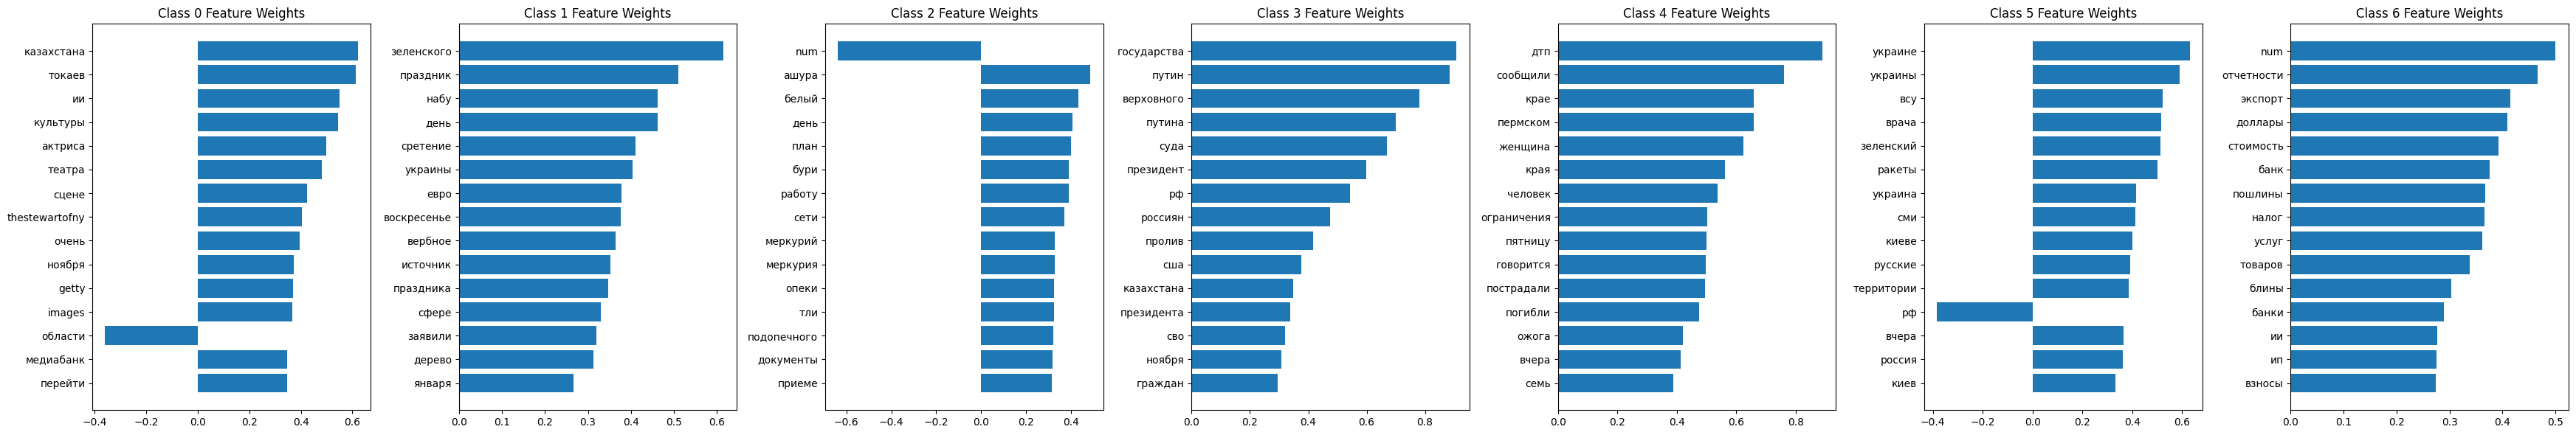


2. Feature Importance - Tree Model


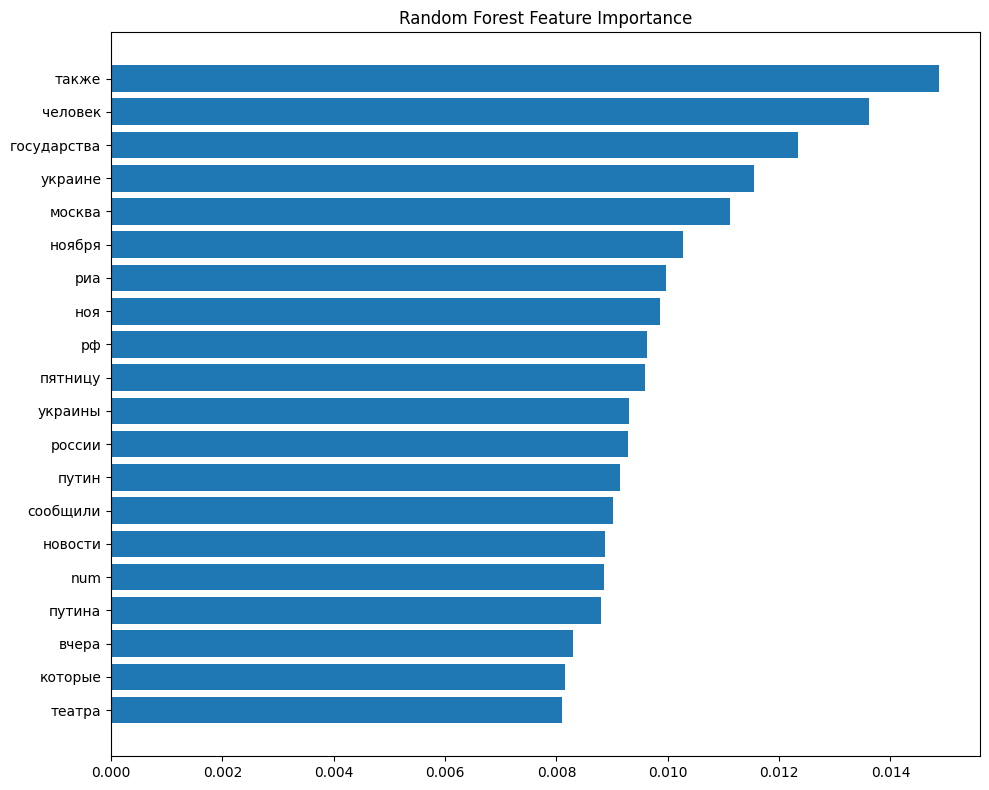


3. Confusion Matrix - Logistic Regression


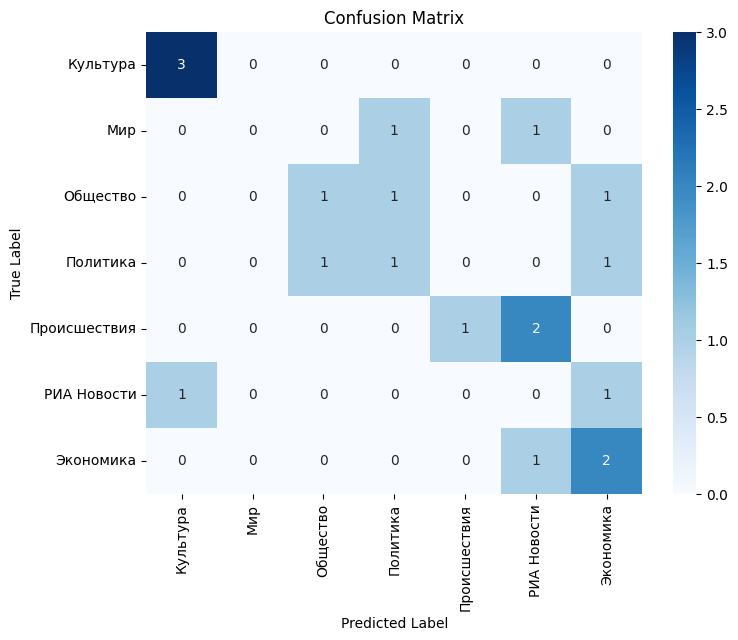


4. Confusion Matrix - Random Forest


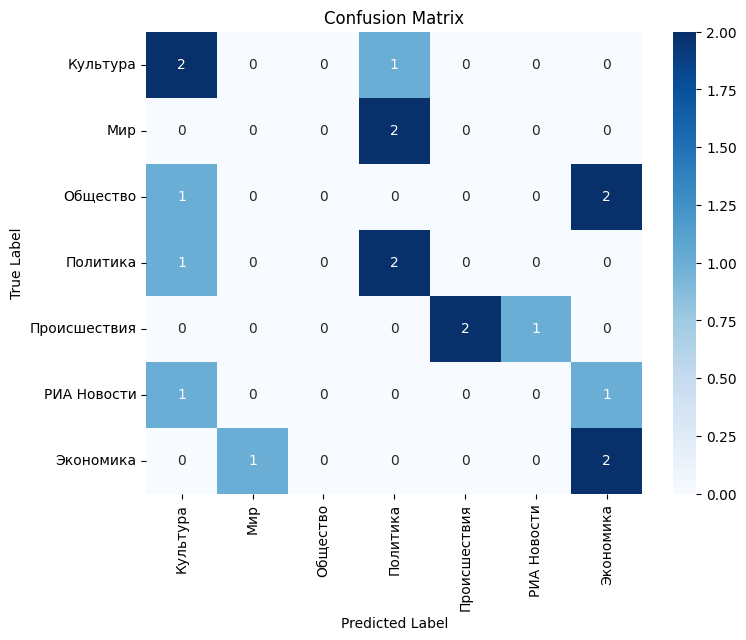


5. Error Analysis - Logistic Regression
Error Analysis Sample (first 10 errors):
                                                text    true_class  \
0  президент палестины махмуд аббас mahmoud abbas...      Политика   
1  москва <NUM> ноя - риа новости. лукойл ведет п...     Экономика   
2  оглавление выплаты льготы участникам сво кому ...   РИА Новости   
3  москва <NUM> ноя риа новости анастасия савенко...   РИА Новости   
4  москва <NUM> ноя риа новости. одна двух линий ...  Происшествия   
5  оглавление суть банкротства физических лиц фз ...      Общество   
6  оглавление даты место проведения организатор т...      Общество   
7  москва <NUM> ноя - риа новости. государство тр...           Мир   
8  оглавление россии стартует единый день голосов...      Политика   
9  донецк <NUM> ноя - риа новости. украинские вой...  Происшествия   

  predicted_class  
0       Экономика  
1     РИА Новости  
2       Экономика  
3        Культура  
4     РИА Новости  
5       Экономика  
6      

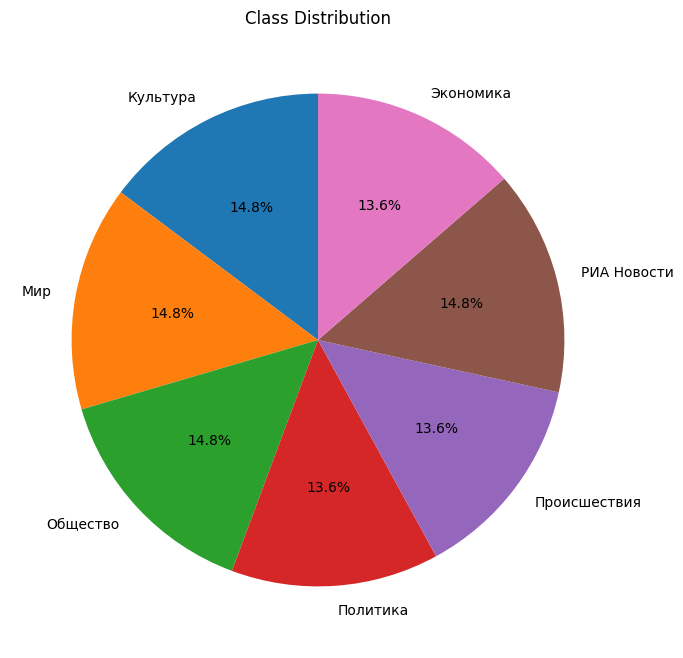


Model Performance Summary:
Logistic Regression Accuracy: 0.4211
Random Forest Accuracy: 0.4211


In [31]:
def load_data():
    train_df = pd.read_json('train.jsonl', lines=True)
    test_df = pd.read_json('test.jsonl', lines=True)
    return train_df, test_df

def prepare_features_and_labels(train_df, test_df):
    vectorizer = TfidfVectorizer(max_features=1000)
    X_train = vectorizer.fit_transform(train_df['text'])
    X_test = vectorizer.transform(test_df['text'])
    
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(train_df['category'])
    y_test = encoder.transform(test_df['category'])
    
    return X_train, X_test, y_train, y_test, vectorizer, encoder

def plot_feature_importance_linear(model, vectorizer, top_n=15):
    feature_names = vectorizer.get_feature_names_out()
    coefficients = model.coef_
    num_classes = coefficients.shape[0]
    
    fig, axes = plt.subplots(1, num_classes, figsize=(5*num_classes, 6))
    
    if num_classes == 1:
        axes = [axes]
    
    for i in range(num_classes):
        class_coef = coefficients[i]
        top_indices = np.argsort(np.abs(class_coef))[-top_n:]
        top_features = [feature_names[j] for j in top_indices]
        top_weights = class_coef[top_indices]
        
        axes[i].barh(range(len(top_features)), top_weights)
        axes[i].set_yticks(range(len(top_features)))
        axes[i].set_yticklabels(top_features)
        axes[i].set_title(f'Class {i} Feature Weights')
    
    plt.tight_layout()
    plt.show()

def plot_feature_importance_tree(model, vectorizer, top_n=20):
    feature_names = vectorizer.get_feature_names_out()
    importances = model.feature_importances_
    
    top_indices = np.argsort(importances)[-top_n:]
    top_features = [feature_names[i] for i in top_indices]
    top_scores = importances[top_indices]
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(top_features)), top_scores)
    plt.yticks(range(len(top_features)), top_features)
    plt.title('Random Forest Feature Importance')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def analyze_errors(X_test, y_test, y_pred, texts, class_names):
    errors_mask = y_test != y_pred
    error_indices = np.where(errors_mask)[0]
    
    error_analysis = pd.DataFrame({
        'text': texts[error_indices],
        'true_class': [class_names[i] for i in y_test[error_indices]],
        'predicted_class': [class_names[i] for i in y_pred[error_indices]]
    })
    
    print("Error Analysis Sample (first 10 errors):")
    print(error_analysis.head(10))
    
    error_counts = error_analysis.groupby(['true_class', 'predicted_class']).size().reset_index(name='count')
    print("\nMost Common Error Patterns:")
    print(error_counts.sort_values('count', ascending=False).head(10))
    
    return error_analysis

def plot_class_distribution_pie(y, class_names):
    class_counts = np.bincount(y)
    
    plt.figure(figsize=(8, 8))
    plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=90)
    plt.title('Class Distribution')
    plt.show()

def main():
    train_df, test_df = load_data()
    
    X_train, X_test, y_train, y_test, vectorizer, encoder = prepare_features_and_labels(train_df, test_df)
    class_names = encoder.classes_
    
    print(f"Number of classes: {len(class_names)}")
    print(f"Classes: {class_names}")
    
    print("Training Logistic Regression...")
    lr_model = LogisticRegression(random_state=42, max_iter=1000)
    lr_model.fit(X_train, y_train)
    y_pred_lr = lr_model.predict(X_test)
    
    print("Training Random Forest...")
    rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    
    print("\n1. Feature Importance - Linear Model")
    plot_feature_importance_linear(lr_model, vectorizer)
    
    print("\n2. Feature Importance - Tree Model")
    plot_feature_importance_tree(rf_model, vectorizer)
    
    print("\n3. Confusion Matrix - Logistic Regression")
    plot_confusion_matrix(y_test, y_pred_lr, class_names)
    
    print("\n4. Confusion Matrix - Random Forest")
    plot_confusion_matrix(y_test, y_pred_rf, class_names)
    
    print("\n5. Error Analysis - Logistic Regression")
    error_analysis_lr = analyze_errors(X_test, y_test, y_pred_lr, test_df['text'].values, class_names)
    
    print("\n6. Error Analysis - Random Forest")
    error_analysis_rf = analyze_errors(X_test, y_test, y_pred_rf, test_df['text'].values, class_names)
    
    print("\n7. Class Distribution")
    plot_class_distribution_pie(y_train, class_names)
    
    lr_accuracy = np.mean(y_test == y_pred_lr)
    rf_accuracy = np.mean(y_test == y_pred_rf)
    
    print(f"\nModel Performance Summary:")
    print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
    print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

main()